# Identify river intersection locations in Northeast New Mexico

This notebook uses the GeoAnalytics Engine [spatial type (ST)](https://developers.arcgis.com/geoanalytics/sql-functions/) functions and [tools](https://developers.arcgis.com/geoanalytics/tools/) to analyze a river dataset in Northeast New Mexico. This notebook will find intersecting rivers, group them by distance and represent them using ellipses.

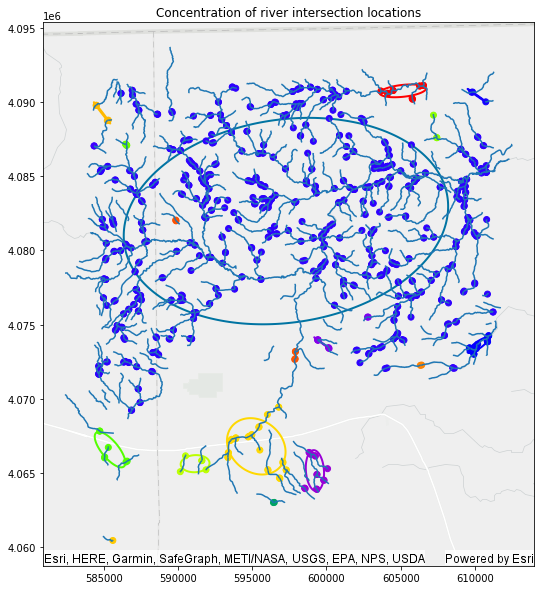

### Workflow overview:
1. Read in a [`feature service`](#feature-service) representing rivers.
2. [`Visualize`](#visualize) the data using a plot and clean the dataset to remove erroneous rivers.
2. Use [`ST_touches`](#touches) to find which rivers touch each other.
3. Find where rivers intersect with [`ST_intersection`](#intersection).
4. Convert river intersection multipoints to points with [`ST_pointN`](#pointn).
5. Use the [`Group By Proximity`](#proximity) tool to group river intersection points by their distance to one another.
7. Generate ellipse rings around groups with [`ST_aggr_stddev_ellipse`](#ellipse).

In [37]:
# Import the modules and functions and authorize geoanalytics
import geoanalytics 
from geoanalytics.sql import functions as ST
from pyspark.sql import functions as F
from geoanalytics.tools import GroupByProximity

geoanalytics.auth(username="username", password="password")

## Data prep, review, and cleaning
Load the rivers dataset from a [feature service](https://developers.arcgis.com/geoanalytics/tutorials/data/read-from-feature-services/) into a Spark DataFrame. <a name="feature-service" /> 

In [38]:
rivers_fs ="https://services1.arcgis.com/36PP9fe9l4BSnArw/ArcGIS/rest/services/Flowlines/FeatureServer/0"
rivers_df = spark.read.format('feature-service').load(rivers_fs)

### When reading in spatial data, check that your geomtery is set correctly using [`get_geometry_field()`](https://developers.arcgis.com/geoanalytics/api-reference/geoanalytics.extensions.html#get-geometry-field) and that the data is represented as expected. 

Because this analysis is local to New Mexico, use a local projected coordinate system for analysis and plotting. [Transform](https://developers.arcgis.com/geoanalytics/sql-functions/st_transform/) the data to a 
[projected coordinate system](https://www.esri.com/arcgis-blog/products/arcgis-pro/mapping/coordinate-systems-difference/). In this case, use one local to New Mexico, like UTM Zone 13, wkid = 26713.

Verify the spatial reference has been updated, the schema, and the record count.<a name="pr"/> 

In [39]:
# View the current field representing geometry and transform the spatial reference
print(rivers_df.st.get_geometry_field())
rivers_df = rivers_df.withColumn("shape", ST.transform(geometry="shape", sr=26713))

# Review the dataset schema, that the transformation was applied, and the number of records
rivers_df.printSchema()
print(rivers_df.st.get_spatial_reference())
print(f"Total number of rivers: {rivers_df.count()}")

shape
root
 |-- FID: integer (nullable = false)
 |-- Permanent_: string (nullable = true)
 |-- FDate: timestamp (nullable = true)
 |-- Resolution: integer (nullable = true)
 |-- GNIS_ID: string (nullable = true)
 |-- GNIS_Name: string (nullable = true)
 |-- LengthKM: double (nullable = true)
 |-- ReachCode: string (nullable = true)
 |-- FlowDir: integer (nullable = true)
 |-- WBArea_Per: string (nullable = true)
 |-- FType: integer (nullable = true)
 |-- FCode: integer (nullable = true)
 |-- MainPath: integer (nullable = true)
 |-- InNetwork: integer (nullable = true)
 |-- Visibility: integer (nullable = true)
 |-- GLOBALID: string (nullable = true)
 |-- Shape_Leng: double (nullable = true)
 |-- Shape__Length: double (nullable = true)
 |-- shape: linestring (nullable = true)

SpatialReference(srid=26713, is_projected=True, unit='Meter', wkt='PROJCS["NAD_1927_UTM_Zone_13N",GEOGCS["GCS_North_American_1927",DATUM["D_North_American_1927",SPHEROID["Clarke_1866",6378206.4,294.9786982]],PRIME

Next, plot the linestrings to verify the dataset looks correct. <a name="visualize" />

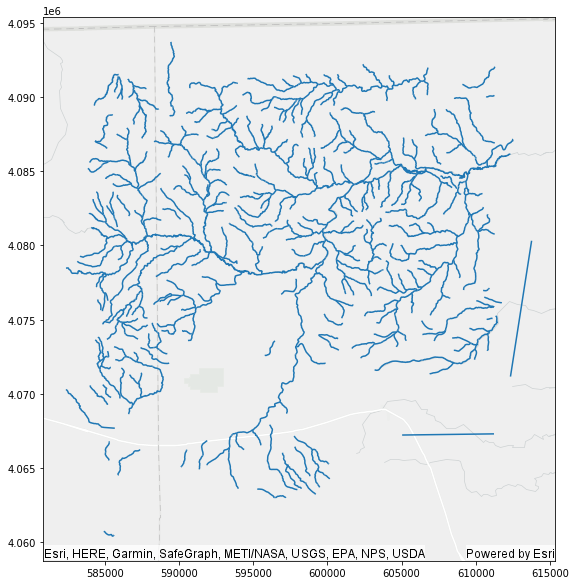

In [40]:
flow_ax = rivers_df.st.plot(basemap="light",figsize=(10,10));

In the plot, there are two straight lines on the bottom right that are unexpected. The next step is to identify and remove the lines to clean the dataset. 

To remove the two outlier lines, look for characteristics that can be used to identify them. In this case they seem like they are straight lines, with only two verticies, and they are fairly long. To try and find them:

- Find river segments with two points
- Sort the two point segments to find the two longest segments

+-------------------------------------------------------------------------------------------------------------------------------+---+
|shape                                                                                                                          |FID|
+-------------------------------------------------------------------------------------------------------------------------------+---+
|{"hasZ":true,"hasM":true,"paths":[[[612339.0395948103,4071155.234377614,0,null],[613764.0558637525,4080310.644206134,0,null]]]}|914|
|{"hasZ":true,"hasM":true,"paths":[[[605038.3676837529,4067215.543362461,0,null],[611228.8823752286,4067293.818633117,0,null]]]}|913|
+-------------------------------------------------------------------------------------------------------------------------------+---+
only showing top 2 rows



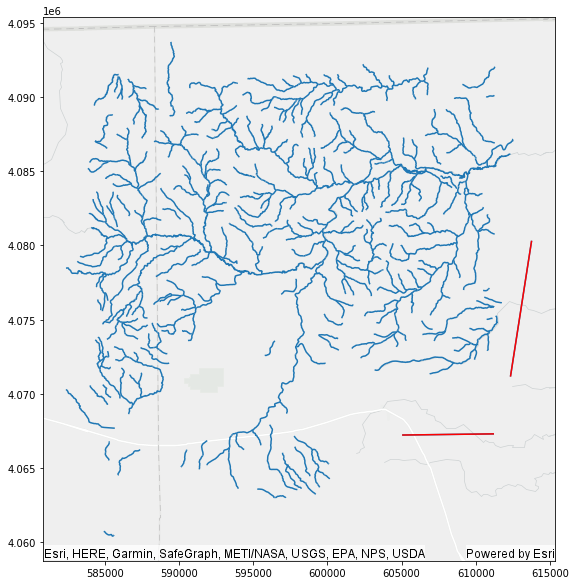

In [41]:
# Find segments with the number of points = 2, and sort the length in descending order, return the top 2
rivers_df.where(ST.num_points("shape") == 2).select("shape", "FID").\
    sort(ST.length("shape").desc()).show(2, truncate=False)

# Filter out the FID values that match the output above
rivers_filter = rivers_df.filter("FID == 914 OR FID == 913")

# Plot all lines in blue, and the filtered lines on top in green to verify they are the correct lines
flow_ax = rivers_df.st.plot(figsize=(10,10));
rivers_filter.st.plot(ax=flow_ax, figsize=(10,10), edgecolor="red", basemap="light");

From the plot, you can see that the two yellow lines are the correct records to remove. Next, create a new DataFrame without them.

Count of rivers in the new DataFrame: 912


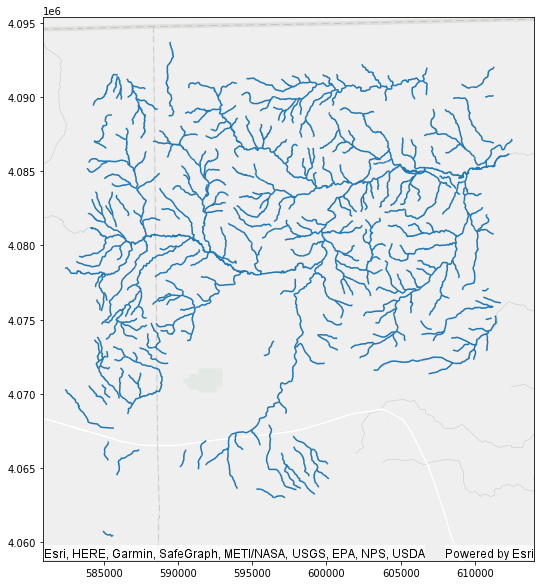

In [42]:
# Create the new DataFrame
rivers_cleaned_df = rivers_df.where("FID != 914 AND FID != 913")

# Verify the count is two less than before (914-2 = 912) and plot
print("Count of rivers in the new DataFrame: {0}".format(rivers_cleaned_df.count()))
rivers_cleaned_df.st.plot(figsize=(10,10), basemap="light");

Alternatively, these rivers could have been found and removed by looking at the values in the DataFrame columns. By examining the summary of these fields, there are values that are unexpectedly 0.

In [43]:
rivers_df.select("LengthKM", "Visibility").summary().show()
rivers_df_filtered = rivers_df.where("LengthKM > 0")
rivers_df_filtered.select("LengthKM", "Visibility").summary().show()
print("Count of rivers in the new DataFrame: {0}".format(rivers_df_filtered.count()))

+-------+------------------+------------------+
|summary|          LengthKM|        Visibility|
+-------+------------------+------------------+
|  count|               914|               914|
|   mean|0.7835796816630202| 603271.3347921226|
| stddev|0.8436494971559212|1277072.8607583907|
|    min|               0.0|                 0|
|    25%|             0.079|             50000|
|    50%|             0.567|            100000|
|    75%|              1.18|            250000|
|    max|             6.392|           5000000|
+-------+------------------+------------------+

+-------+------------------+-----------------+
|summary|          LengthKM|       Visibility|
+-------+------------------+-----------------+
|  count|               912|              912|
|   mean|0.7852980581578952| 604594.298245614|
| stddev|0.8437749175759599|1278160.729990886|
|    min|             0.006|            24000|
|    25%|              0.08|            50000|
|    50%|             0.571|           100000|


## Find touching and intersecting rivers
Now that the dataset has been cleaned, find points where two or more rivers connect to each other. To do this, join the same dataset to itself (self-join) using the [`ST.touches`](https://developers.arcgis.com/geoanalytics/sql-functions/st_touches/) operation to find the number of intersecting rivers and then create intersection points. <a name="touches" />

In [44]:
river_lines = rivers_cleaned_df.select("shape")

In [45]:
candidates = river_lines.alias("lines1").join(river_lines.alias("lines2"), 
                                              ST.touches(geometry1="lines1.shape", geometry2="lines2.shape")).distinct()
candidates.count()

2190

Use [`ST_intersection`](https://developers.arcgis.com/geoanalytics/sql-functions/st_intersection/) to create a point at every river intersection and call PySpark's built-in distinct function to remove duplicates. Notice that `ST_intersection` returns multipoints when the output is specified to be points. <a name="intersection" />

In [46]:
renamed_cand = candidates.toDF("geometry1","geometry2")
renamed_cand.printSchema()

intersection_points = renamed_cand.select(ST.intersection(geometry1="geometry1", geometry2="geometry2", intersect_type="point")\
                                          .alias("intersection_points")).distinct()
intersection_points.printSchema()
print("Intersection point count: {0}".format(intersection_points.count()))

root
 |-- geometry1: linestring (nullable = true)
 |-- geometry2: linestring (nullable = true)

root
 |-- intersection_points: multipoint (nullable = true)

Intersection point count: 869


Use [`ST_GeometryType`](https://developers.arcgis.com/geoanalytics/sql-functions/st_geometry_type/) to get the geometry type for every row. <a name="geometrytype" />

In [47]:
intersection_points.select(ST.geometry_type("intersection_points")).distinct().show()

+------------------------------------+
|ST_GeometryType(intersection_points)|
+------------------------------------+
|                          MultiPoint|
+------------------------------------+



Next, plot the river intersection points on top of the rivers by passing the flow lines plot axes to the intersection points plot.

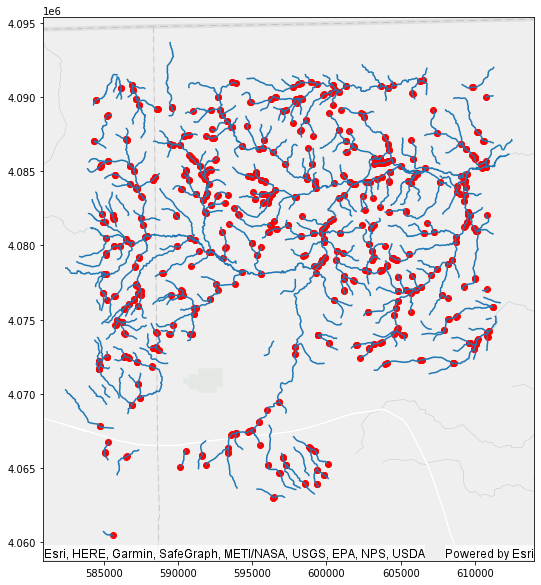

In [48]:
rivers_ax = rivers_cleaned_df.st.plot(figsize=(10,10))
intersection_points.st.plot(ax=rivers_ax,color="red", basemap="light");

For these intersections, the multipoints all consist of a single point. To modify the multipoints to points, use [`ST_pointN`](https://developers.arcgis.com/geoanalytics/sql-functions/st_point_n/) to get a specific point from the multipoint geometry. In this case, return the first point in the multipoint. <a name="pointn" />

In [49]:
points = intersection_points.select(ST.point_n(geometry="intersection_points", n=0).alias("points"))
points.count()
points.printSchema()

root
 |-- points: point (nullable = true)



## Find groups of river intersections
Creating the river intersection points and plotting them on the map is useful for visualizing the connections in the river network. To discover which areas have the highest concentration of river connections, group points that are near each other using the [Group By Proximity tool](https://developers.arcgis.com/geoanalytics/tools/group-by-proximity/). <a name="proximity" />

In [50]:
grouped_intersections = GroupByProximity()\
    .setSpatialRelationship(spatial_relationship="NearPlanar", near_distance=1, near_distance_unit='Miles') \
    .run(dataframe=intersection_points)
print("Number of distinct groups of intersections: {0}".format(grouped_intersections.select("GROUP_ID").distinct().count()))
grouped_intersections.printSchema()

Number of distinct groups of intersections: 20
root
 |-- intersection_points: multipoint (nullable = true)
 |-- GROUP_ID: long (nullable = true)



Another common application of the Group By Proximity tool is finding rivers (or any line networks) that touch, to generate a representation of the watersheds. Below, use Group by Proximity to calculate the watersheds to visualize the results beside the grouped river intersections. 

In [51]:
grouped_rivers = GroupByProximity()\
    .setSpatialRelationship(spatial_relationship="Touches") \
    .run(dataframe=rivers_cleaned_df)
print("Number of distinct groups of rivers that touch: {0}".format(grouped_rivers.select("GROUP_ID").distinct().count()))
grouped_rivers.printSchema()

Number of distinct groups of rivers that touch: 48
root
 |-- FID: integer (nullable = false)
 |-- Permanent_: string (nullable = true)
 |-- FDate: timestamp (nullable = true)
 |-- Resolution: integer (nullable = true)
 |-- GNIS_ID: string (nullable = true)
 |-- GNIS_Name: string (nullable = true)
 |-- LengthKM: double (nullable = true)
 |-- ReachCode: string (nullable = true)
 |-- FlowDir: integer (nullable = true)
 |-- WBArea_Per: string (nullable = true)
 |-- FType: integer (nullable = true)
 |-- FCode: integer (nullable = true)
 |-- MainPath: integer (nullable = true)
 |-- InNetwork: integer (nullable = true)
 |-- Visibility: integer (nullable = true)
 |-- GLOBALID: string (nullable = true)
 |-- Shape_Leng: double (nullable = true)
 |-- Shape__Length: double (nullable = true)
 |-- shape: linestring (nullable = true)
 |-- GROUP_ID: long (nullable = true)



<AxesSubplot:>

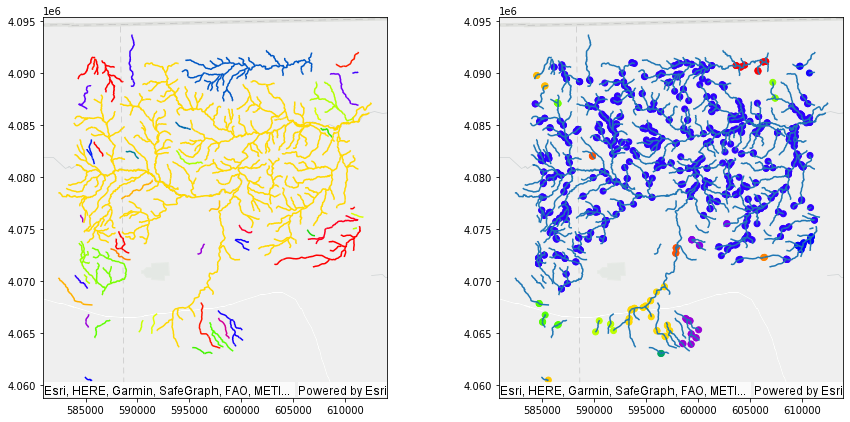

In [59]:
# Plots the grouped rivers (that touch) and grouped river junctions (within 1 mile) beside each other
import matplotlib.pyplot as plt
fix, ax = plt.subplots(nrows=1,ncols=2, figsize=(15,7))
ax[0]._st_sr = 26713
ax[1]._st_sr = 26713
grouped_rivers.st.plot(ax=ax[0], cmap_values="GROUP_ID", cmap="prism", basemap="light")

rivers_cleaned_df.st.plot(ax=ax[1])
grouped_intersections.st.plot(ax=ax[1], cmap_values="GROUP_ID", cmap="prism", basemap="light")

Comparing the two plots, you can see that there are slightly different patterns between the proximity of intersections, and the touching lines. The next steps use the grouped intersections and explore them a bit more.

There are 21 groups for the intersections based on a proximity of 1 mile. Visualize this by passing the cmap_values column as input to the val_col when calling plot and select a categorical color mapping scheme. 

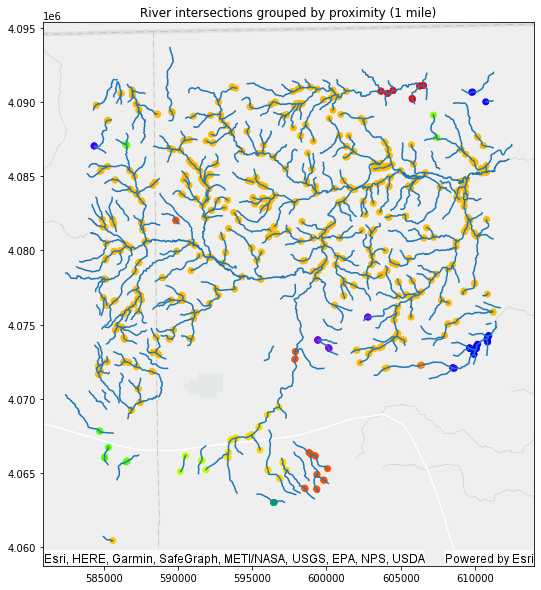

In [25]:
river_ax = rivers_cleaned_df.st.plot(figsize=(10,10))
gx = grouped_intersections.st.plot(ax=river_ax, cmap_values="GROUP_ID", cmap="prism", figsize=(10,10), basemap="light")
gx.set_title("River intersections grouped by proximity (1 mile)");

## Create representative ellipses for each group
Use [`ST_aggr_stddev_ellipse`](https://developers.arcgis.com/geoanalytics/sql-functions/st_aggr_stdev_ellipse/) which is an aggregate function that returns the weighted aggregate standard deviational ellipse of all geometries in the dataset. The default is one-standard deviational ellipse, which covers 63% of the points. <a name="ellipse" />

<AxesSubplot:>

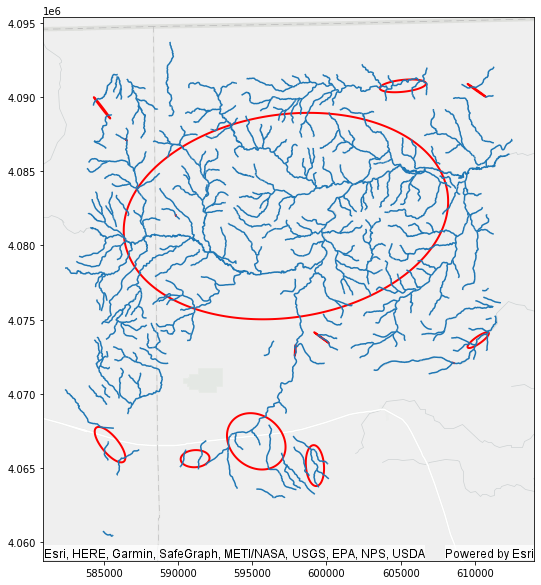

In [32]:
stdev_ellipses = grouped_intersections.groupby("GROUP_ID").agg(ST.aggr_stdev_ellipse("intersection_points").alias("ellipse"))
flax = rivers_cleaned_df.st.plot(figsize=(10,10))
stdev_ellipses.st.plot(ax=flax, figsize=(10,10), facecolor="none", edgecolor="red", linewidth=2, basemap="light")

## Plot results
Putting everything together, plot the rivers, their intersection points grouped by proximity, and their direction of distribution. Use the same colors for the grouped points and their representative ellipses.

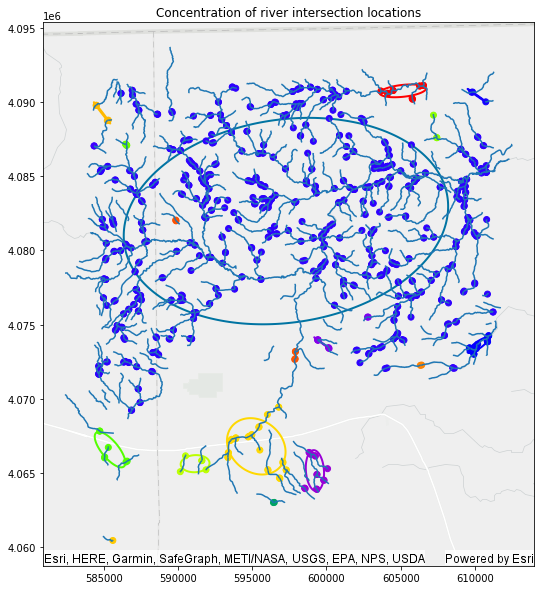

In [36]:
flax = rivers_cleaned_df.st.plot(figsize=(10,10))
px = stdev_ellipses.st.plot(ax=flax, figsize=(10,10), facecolor="none", cmap="prism", cmap_values="GROUP_ID",  linewidth=2)
gx = grouped_intersections.st.plot(ax=px, cmap_values="GROUP_ID", cmap="prism", figsize=(10,10), basemap="light")
gx.set_title("Concentration of river intersection locations");